In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

categ.vocal_channel = categ.estimated_vocal_channel
categ = categ.drop(columns=["estimated_vocal_channel"])

# quant = quant[categ.vocal_channel =="song"]
# categ = categ[categ.vocal_channel=="song"]
# categ = categ.drop(columns= ["vocal_channel"])

from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.pipeline import make_pipeline
display(categ)

,vocal_channel,emotion,emotional_intensity,statement,repetition,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,F
1,speech,angry,normal,Dogs are sitting by the door,1st,F
2,speech,happy,strong,Dogs are sitting by the door,2nd,F
3,speech,surprised,normal,Kids are talking by the door,1st,F
4,song,happy,strong,Dogs are sitting by the door,2nd,F
...,...,...,...,...,...,...
2426,speech,calm,strong,Kids are talking by the door,1st,M
2427,speech,calm,normal,Dogs are sitting by the door,1st,M
2428,song,sad,strong,Dogs are sitting by the door,2nd,M
2429,speech,surprised,normal,Kids are talking by the door,1st,M


In [2]:
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score

def meanAMI(labels, dataframe):
    mAMI= 0 
    
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        mAMI += featAMI/len(dataframe.columns)
    return mAMI

def get_maxAMI_feature(labels, dataframe):
    MAMI = 0
    MAMIfeat = dataframe.columns[0]
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        MAMIfeat = feat if featAMI > MAMI else MAMIfeat
        MAMI = max(MAMI, featAMI)
    return MAMIfeat, MAMI


In [3]:
def greedy_optimizer(classifier, method="AMI"):
    """chooses the features tat maximise the classifier performance"""
    features = list(quant.columns)
    combos = [[col] for col in features]
    best_features = []
    for i in range(2):
        scores = []
        categories = []
        amis = []
        nlabels = []

        for feat in combos:
            Y = quant[feat]
            classifier.fit(Y)
            labels = classifier.steps[1][1].labels_

            if method == "AMI":
                s = meanAMI(labels, categ)
            elif method == "silhouette":
                filter_outliers = (labels != -1)
                if len(np.unique(labels[filter_outliers])) > 1:
                    s = silhouette_score(Y[filter_outliers], labels[filter_outliers])
                else:
                    s = -1
            elif method == "sil_over_noise":
                filter_outliers = (labels != -1)
                if len(np.unique(labels[filter_outliers])) > 1:
                    s = silhouette_score(Y[filter_outliers], labels[filter_outliers])/np.sum(np.logical_not(filter_outliers))
                else:
                    s = -1
            else:
                print("optimizing method not in list")
            maxAMIfeat, MAMI = get_maxAMI_feature(labels, categ)
            scores.append(s)
            categories.append(maxAMIfeat)
            amis.append(MAMI)
            nlabels.append(len(np.unique(labels)))
        
        best_score_index = np.argmax(scores)
        best_features.append(features[best_score_index])
        combos = [best_features + [f] for f in features if f not in best_features]
        features.remove(features[best_score_index]) 

        print(f"best {method} is for {best_features} (S = {scores[best_score_index]}). Best match in category {categories[best_score_index]} ({amis[best_score_index]}), nlabels = {nlabels[best_score_index]}")
    return best_features[0], best_features[1], scores[best_score_index], nlabels[best_score_index]


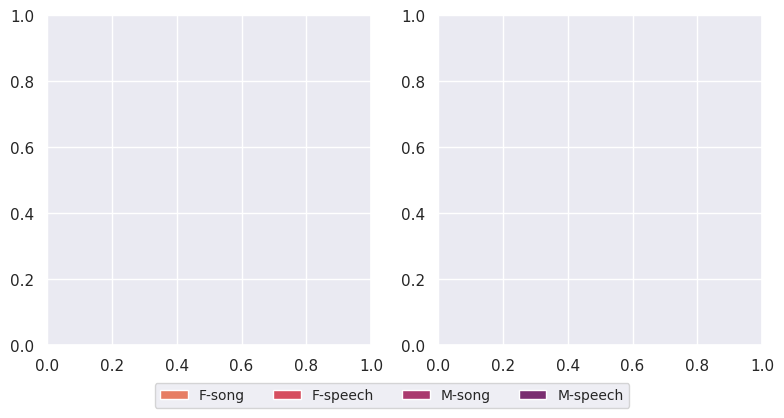

In [32]:
from matplotlib.patches import Patch
cmap= sns.color_palette("flare", 4)

fig, (ax2, ax1) = plt.subplots(1,2, figsize=(8,4))

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(4))}
get_codes = lambda x: np.vectorize(map_classes.get)(x)
codes = get_codes(classes).reshape(-1)

legend_elements = [ Patch(facecolor=cmap[0], label=unique_classes[0]),
                     Patch(facecolor=cmap[1], label=unique_classes[1]),
                     Patch(facecolor=cmap[2], label=unique_classes[2]),
                     Patch(facecolor=cmap[3], label=unique_classes[3])]

fig.legend(handles=legend_elements, loc='center', fontsize=10, bbox_to_anchor=(0.5,-0.01), ncols=4);

In [33]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans
scaler = QuantileTransformer(output_distribution="normal")
kmeans = KMeans(n_clusters=7, n_init=5)
model = make_pipeline(scaler, kmeans)
f1, f2, *_ = greedy_optimizer(model, method="AMI")#["length_ms", "stft_min"] #greedy_optimizer(model, method="AMI")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax1, palette="flare", grid_resolution=400)

sns.scatterplot(data=quant, x=f1, y=f2,s=5, hue=codes, palette=cmap,marker="s", ax=ax1, edgecolor=None, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax1, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5,alpha=0.8)

ax1.set_xlim(min(quant[f1]), max(quant[f1]))
ax1.set_ylim(min(quant[f2]), max(quant[f2]))
transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax1, legend=False)
for i, center in enumerate(transf_centers):
    ax1.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
# plt.savefig("KMEANS-7clusters.pdf")

best AMI is for ['length_ms'] (S = 0.07473788014765509). Best match in category vocal_channel (0.3346960881917923), nlabels = 7
best AMI is for ['length_ms', 'mfcc_mean'] (S = 0.09059144548420203). Best match in category vocal_channel (0.27378263296853195), nlabels = 7


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [34]:
kmeans = KMeans(n_clusters=2, n_init=5)
model = make_pipeline(scaler, kmeans)
f1, f2, *_ = greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax2, palette="flare", grid_resolution=400)

sns.scatterplot(data=quant, x=f1, y=f2, s=5, hue=codes, marker="s",palette=cmap, ax=ax2, edgecolor=None, legend=False)

transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax2, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax2, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5, alpha=0.8)
for i, center in enumerate(transf_centers):
    ax2.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
    
ax2.set_xlim(min(quant[f1]), max(quant[f1]))
ax2.set_ylim(min(quant[f2]), max(quant[f2]))

best silhouette is for ['length_ms'] (S = 0.6177397638645183). Best match in category vocal_channel (0.5425537355878731), nlabels = 2
best silhouette is for ['length_ms', 'log_kur'] (S = 0.5095930072568149). Best match in category vocal_channel (0.5223431218823527), nlabels = 2


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:187: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


(0.5640594492138461, 4.078988853081285)

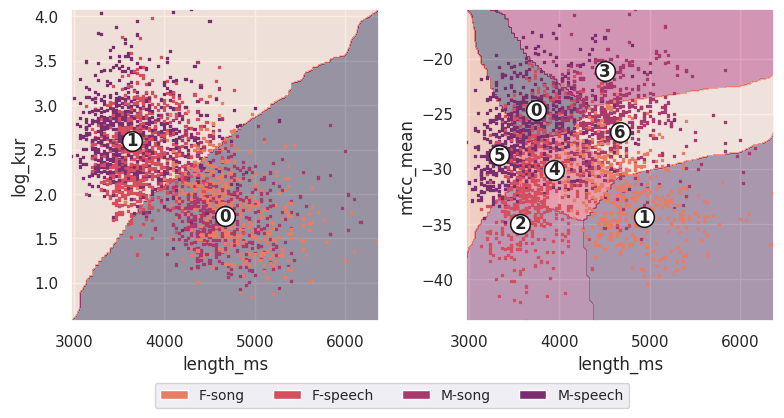

In [35]:
fig.tight_layout()
fig.savefig("kmeans_cluster_2_7.pdf", bbox_inches='tight')
display(fig)

DBSCAN

In [37]:
quant= quant[categ.vocal_channel=="song"]
categ = categ[categ.vocal_channel=="song"].drop(columns=["vocal_channel"])

In [ ]:
from sklearn.cluster import DBSCAN

transformer = StandardScaler()
dbscan_df = pd.DataFrame(columns=["eps", "f1", "f2", "score", "nlabels"])
for eps in np.linspace(0.01,0.4,20 ):
    print(f"eps = {eps}-------------")
    dbscan = DBSCAN(eps=eps, min_samples=5)
    model = make_pipeline(transformer, dbscan)
    f1, f2, score, nlabels = greedy_optimizer(model, method="AMI")
    dbscan_df = pd.concat([dbscan_df, pd.DataFrame({"eps":eps, "f1":f1, "f2":f2, "score":score, "nlabels":nlabels}, index=[0])], ignore_index=True)
    print("----------------------------")

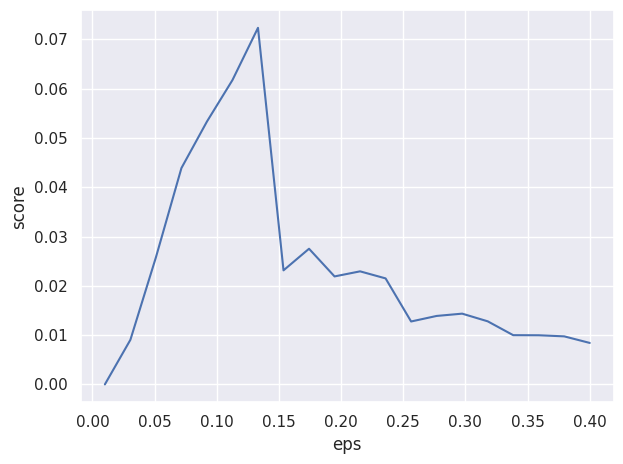

In [ ]:
sns.lineplot(data=dbscan_df, x="eps", y="score")
bastard = np.argmax(dbscan_df.score)
# print(dbscan_df.loc[bastard])
# print(dbscan_df.sort_values(by="score"))

-0.061875469433262956
[-1  0  1  2  3  4  5]
0.6206250817208993
[-1  0  1]


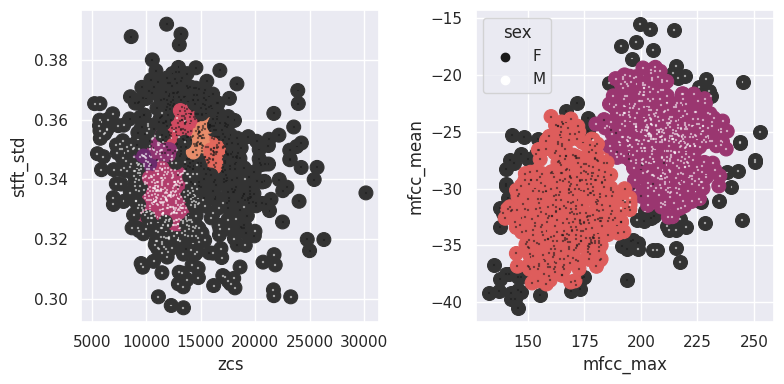

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4));
transformer=StandardScaler()
dbscan = DBSCAN(eps=0.2, min_samples=20)
model = make_pipeline(transformer, dbscan)
f1, f2, *_ =  "zcs", "stft_std", 5 # greedy_optimizer(model, method="AMI")

X = quant[[f1, f2]]
model.fit(X)
labels = model.steps[1][1].labels_
print(silhouette_score(X[labels!=-1], labels[labels!=-1]))
print(np.unique(labels))
classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.emotion)], columns=["class"])
colors = [[0.2,0.2,0.2]] + sns.color_palette("flare", len(np.unique(labels))-1)

sns.scatterplot(data=quant, x=f1, y=f2, s= 100, hue=labels, marker="o", alpha=1, palette=colors, edgecolor=None, legend=False, ax=ax1)
sns.scatterplot(data=quant, x=f1, y=f2, s=2, hue=categ.sex, palette=["k","w"], alpha=0.5, marker="s", edgecolor=None, legend=False, ax=ax1)

############################

dbscan = DBSCAN(eps=0.3, min_samples=20)
model = make_pipeline(transformer, dbscan)
f1, f2, *_ = "mfcc_max", "mfcc_mean", 5 # greedy_optimizer(model, method="sil_over_noise")

X = quant[[f1, f2]]
model.fit(X)
labels = model.steps[1][1].labels_
print(silhouette_score(X[labels!=-1], labels[labels!=-1]))
print(np.unique(labels))
classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.emotion)], columns=["class"])
colors =  sns.color_palette("flare", len(np.unique(labels))-1)

loc_out = (labels==-1)
loc_ok = (labels!=-1)

sns.scatterplot(data=quant[loc_out], x=f1, y=f2, s= 100, marker="o", alpha=1, color=([0.2,0.2, 0.2]) , edgecolor=None, legend=False, ax=ax2)
sns.scatterplot(data=quant[loc_ok], x=f1, y=f2, s= 100, hue=labels[loc_ok], marker="o", alpha=1, palette=colors, edgecolor=None, legend=False, ax=ax2)
sns.scatterplot(data=quant, x=f1, y=f2, s=2, hue=categ.sex, palette=["k","w"], alpha=0.5, marker="s", edgecolor=None, legend=True, ax=ax2)


# ax.set_xlim(min(quant[f1])*(1-0.15), max(quant[f1])*(1+0.15))
# ax.set_ylim(min(quant[f2])*(1+0.15), max(quant[f2])*(1+0.15))
fig.tight_layout()
fig.savefig("images/dbscan.pdf")

<AxesSubplot: xlabel='mfcc_max', ylabel='Density'>

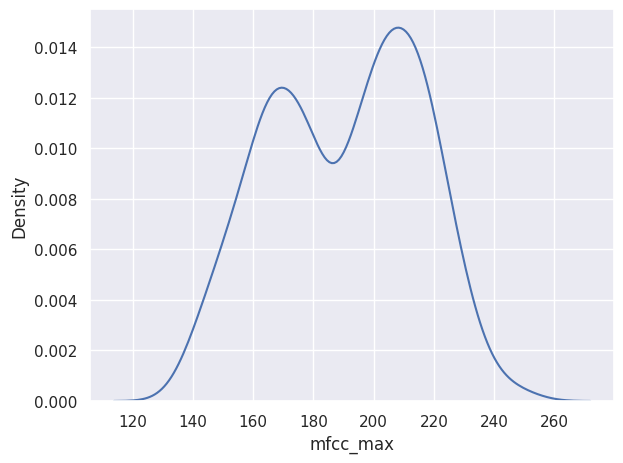

In [ ]:
sns.kdeplot(data=quant, x="mfcc_max")

<AxesSubplot: xlabel='log_stft_min', ylabel='mfcc_mean'>

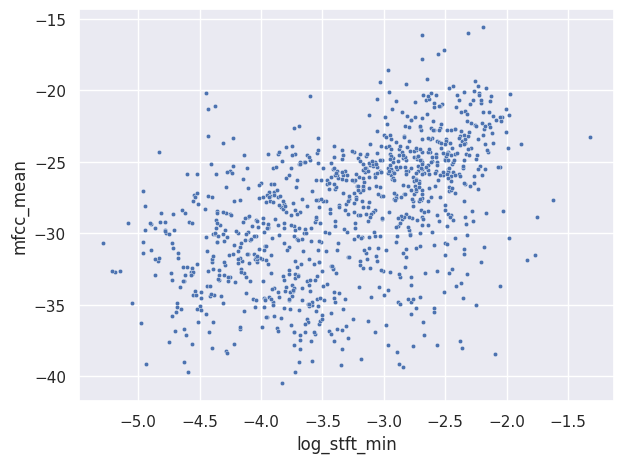

In [ ]:
sns.scatterplot(data=quant, x="log_stft_min", y= "mfcc_mean", s=10)

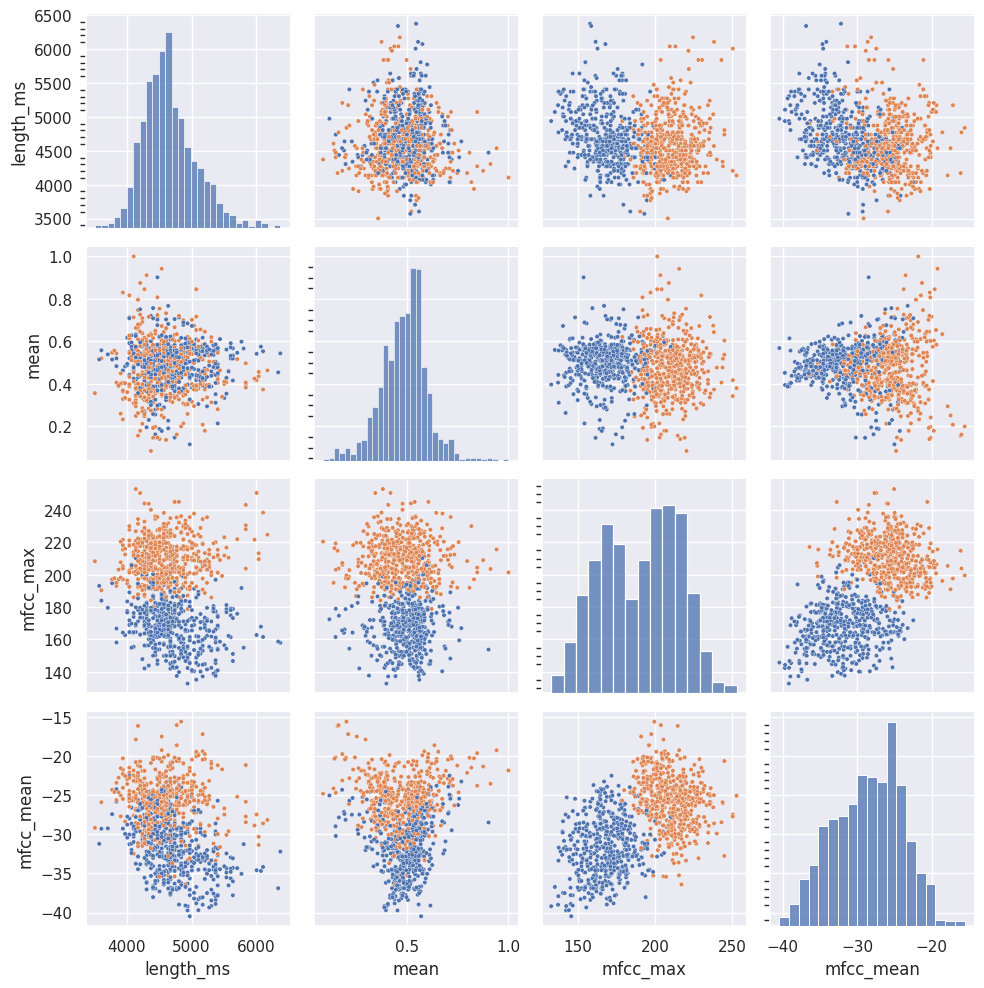

In [ ]:
sns.pairplot(data=quant[quant.columns[0:4]], plot_kws=dict(s=10, hue=categ.sex))

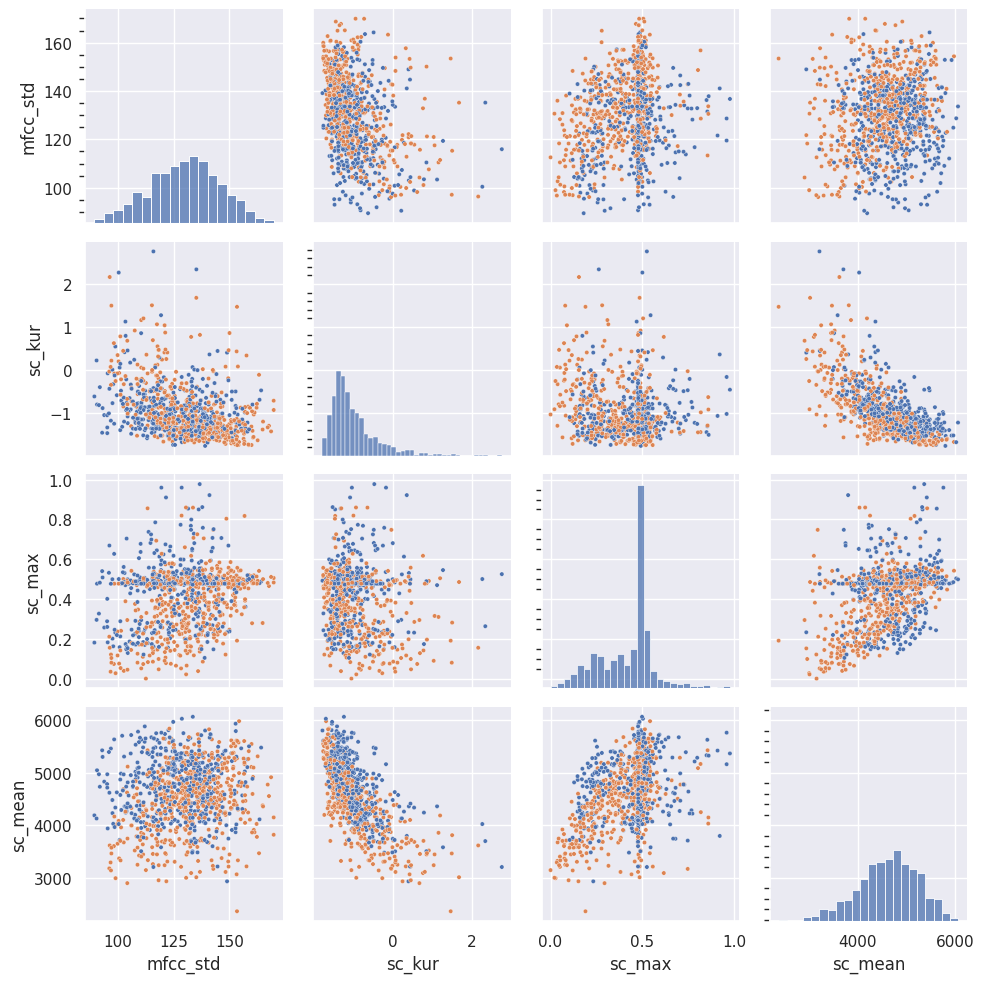

In [ ]:
sns.pairplot(data=quant[quant.columns[4:8]], plot_kws=dict(s=10, hue=categ.sex))

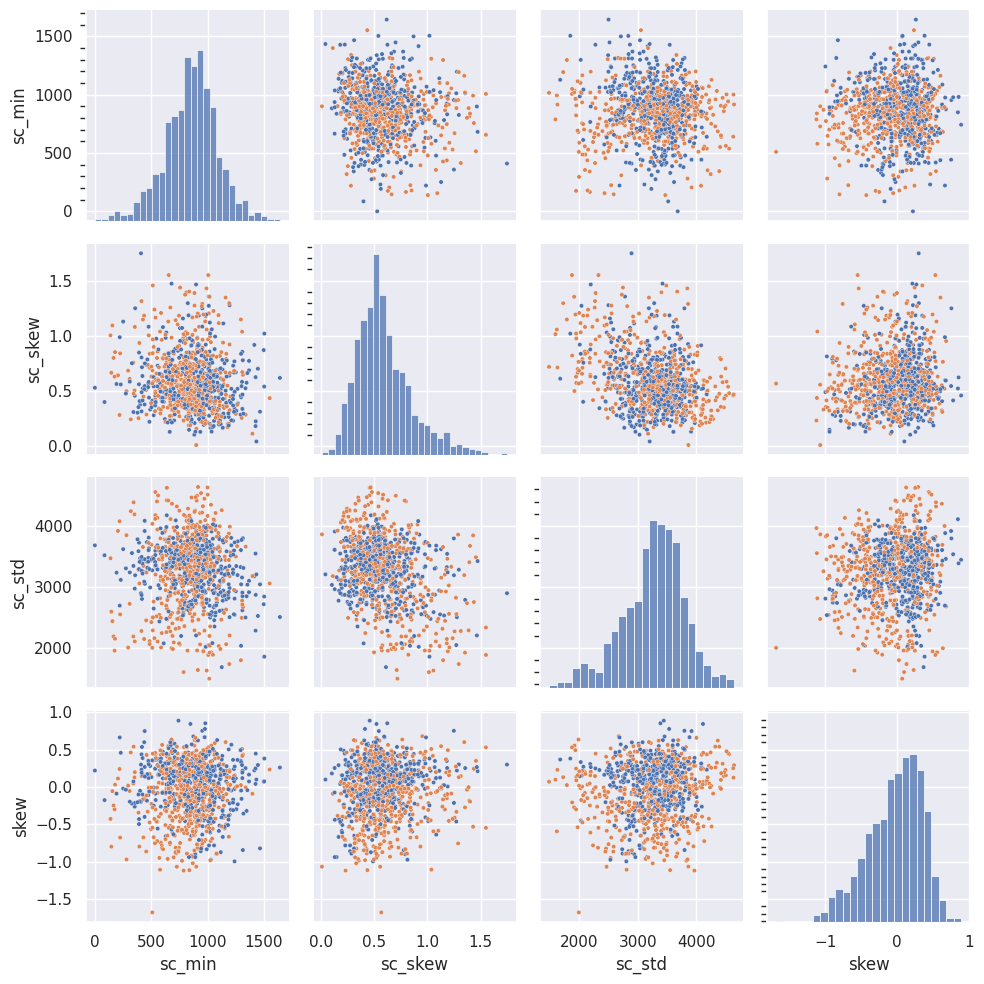

In [ ]:
sns.pairplot(data=quant[quant.columns[8:12]], plot_kws=dict(s=10, hue=categ.sex))

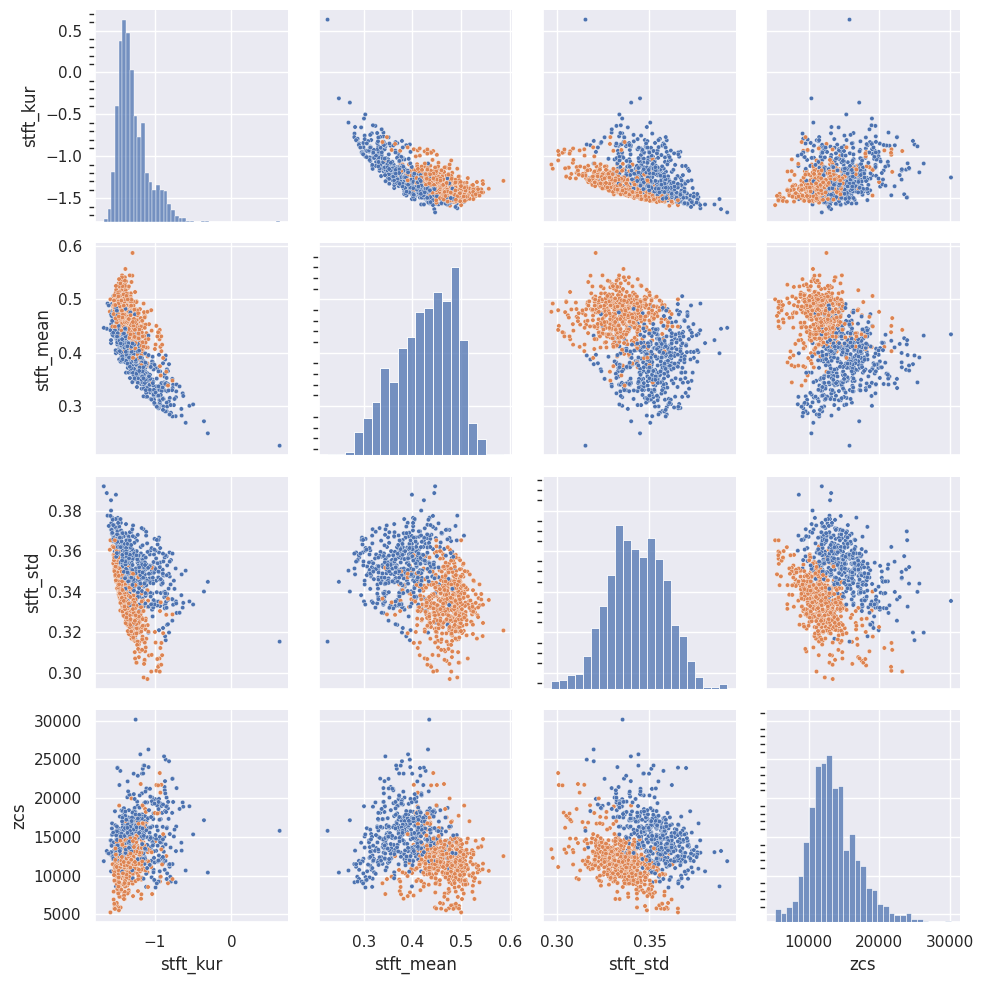

In [ ]:
sns.pairplot(data=quant[quant.columns[12:16]], plot_kws=dict(s=10, hue=categ.sex))